In [1]:
import xgbfir

import pandas as pd
import warnings

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

import category_encoders as ce
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
def evaluate_model_with_ohe(X_train, X_val, y_train, y_val):
    encoder = ce.OneHotEncoder(cols=X_train.select_dtypes(include=['object', 'category']).columns, use_cat_names=True, drop_invariant=True, return_df=True)

    X_train_encoded = encoder.fit_transform(X_train, y_train)
    X_val_encoded = encoder.transform(X_val)
    
    model = XGBClassifier(random_state=42, enable_categorical=True, early_stopping_rounds=100)
    model.fit(X_train_encoded, y_train, eval_set=[(X_train_encoded, y_train), (X_val_encoded, y_val)], verbose=0)
    y_pred = model.predict(X_val_encoded)
    score = f1_score(y_val, y_pred, average='weighted')
    print(f'F1 score: {score}')
    return model, X_train_encoded

In [3]:
def train_and_evaluate(X_train, y_train, X_val, y_val, random_state=42, enable_categorical=True):
    xgb_model = XGBClassifier(random_state=random_state, enable_categorical=enable_categorical)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_val)
    f1_score_val = f1_score(y_val, y_pred, average='weighted')

    return f1_score_val, xgb_model

In [4]:
X = pd.read_csv('../../../data/new_features/df_.csv')
y = pd.read_csv('../../../data/new_features/y.csv')

# for col in X.filter(like='_binned').columns:
#     X[col] = X[col].astype('category')
# 
# X_train_full, X_val_full, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# 
# xgb, X_train_encoded = evaluate_model(X_train_full, X_val_full, y_train, y_val)

In [5]:
# Splitting the original dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

f1,xgb=train_and_evaluate(X_train, y_train, X_val, y_val)
print(f'Base line f1: {f1}')

Base line f1: 0.4949434149168055


In [6]:
xgbfir.saveXgbFI(xgb, feature_names=X_train.columns, OutputXlsxFile='fir.xlsx')

file_path = 'fir.xlsx'
fir = pd.read_excel(file_path)

top_gain_features = fir.sort_values(by='Gain', ascending=False).head(10)
top_fscore_features = fir.sort_values(by='FScore', ascending=False).head(10)
top_wfscore_features = fir.sort_values(by='wFScore', ascending=False).head(10)
top_avg_gain_features = fir.sort_values(by='Average Gain', ascending=False).head(10)
top_expected_gain_features = fir.sort_values(by='Expected Gain', ascending=False).head(10)

top_features_summary = {
    "Top Features by Gain": top_gain_features['Interaction'].values,
    "Top Features by FScore": top_fscore_features['Interaction'].values,
    "Top Features by wFScore": top_wfscore_features['Interaction'].values,
    "Top Features by Average Gain": top_avg_gain_features['Interaction'].values,
    "Top Features by Expected Gain": top_expected_gain_features['Interaction'].values
}

interaction_depth_1 = pd.read_excel(file_path, sheet_name='Interaction Depth 1')
interaction_depth_2 = pd.read_excel(file_path, sheet_name='Interaction Depth 2')

interaction_depth_1_head = interaction_depth_1.sort_values('Average Rank', ascending=True).head(20)
interaction_depth_2_head = interaction_depth_2.sort_values('Average Rank', ascending=True).head(20)

In [7]:
# Preparing data for visualization
interaction_importances = interaction_depth_1[['Interaction', 'Gain', 'FScore', 'Average Gain', 'Expected Gain']]
interaction_importances.set_index('Interaction', inplace=True)

# Normalizing the data for comparison
normalized_interaction_importances = (interaction_importances - interaction_importances.min()) / (interaction_importances.max() - interaction_importances.min())

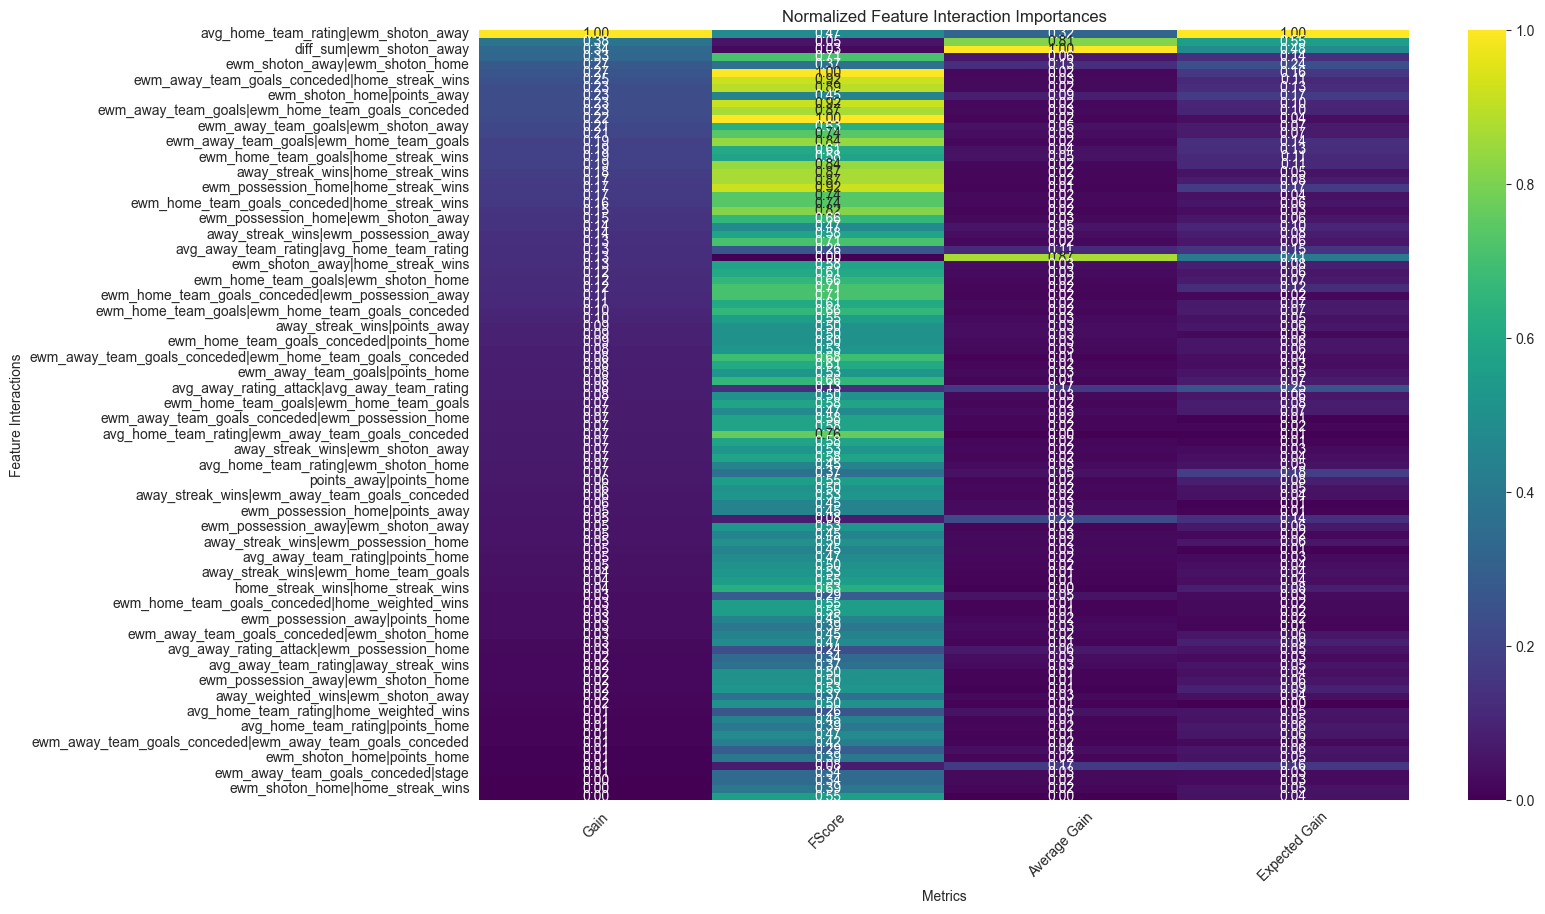

In [8]:
# Re-importing necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Re-plotting the heatmap for general analysis of feature interaction importance
plt.figure(figsize=(15, 10))
sns.heatmap(normalized_interaction_importances, annot=True, cmap='viridis', fmt=".2f")
plt.title('Normalized Feature Interaction Importances')
plt.ylabel('Feature Interactions')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

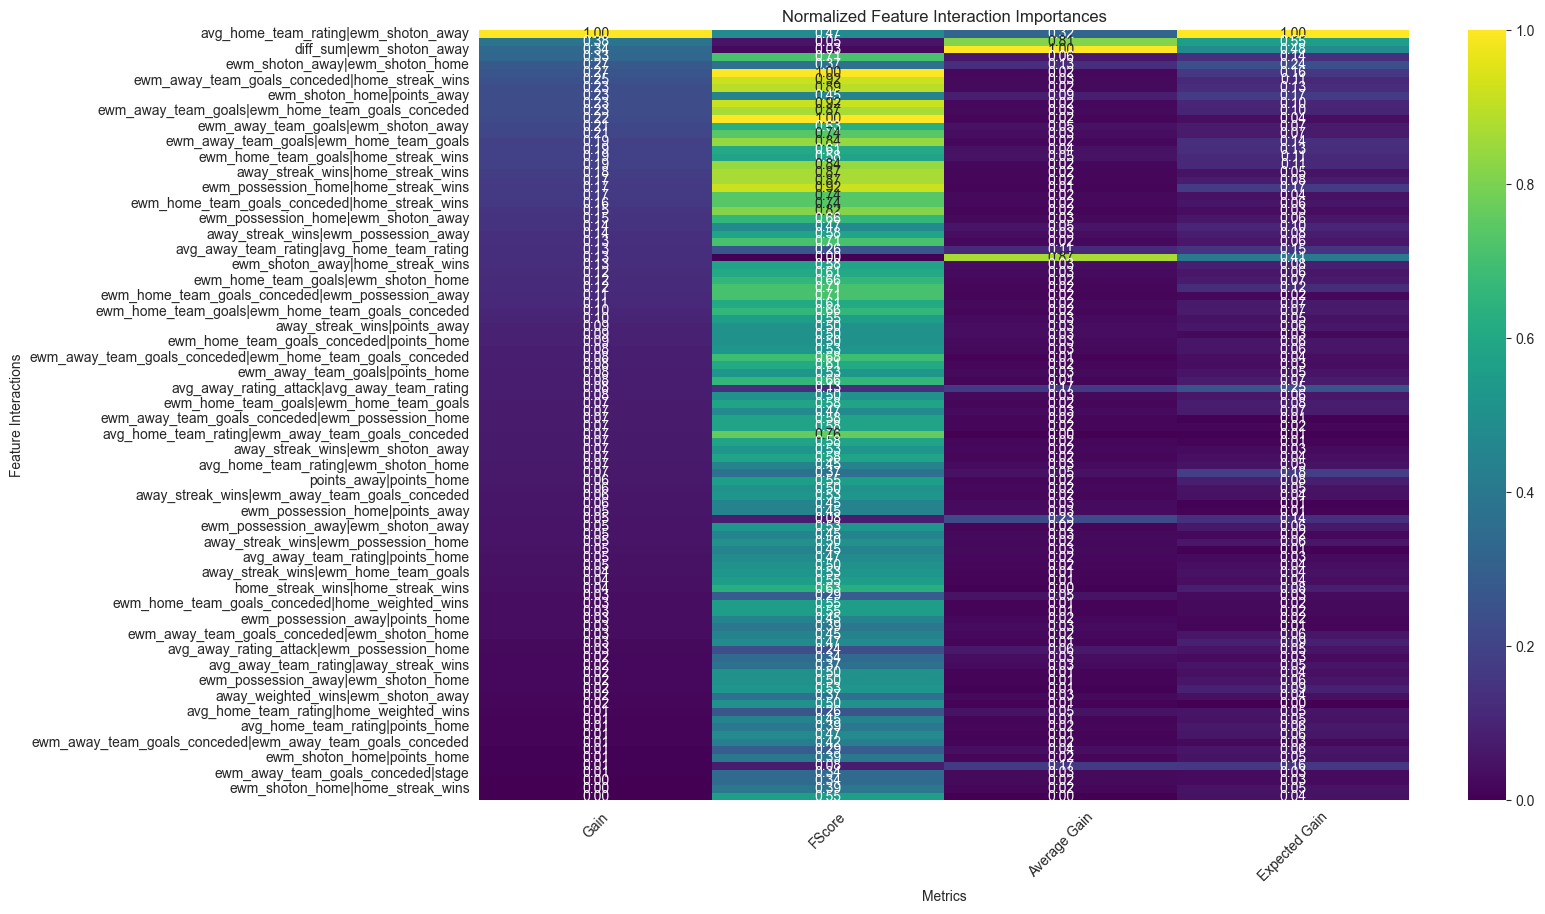

In [9]:
# Re-plotting the heatmap for general analysis of feature interaction importance
plt.figure(figsize=(15, 10))
sns.heatmap(normalized_interaction_importances, annot=True, cmap='viridis', fmt=".2f")
plt.title('Normalized Feature Interaction Importances')
plt.ylabel('Feature Interactions')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [10]:
normalized_interaction_importances

,Gain,FScore,Average Gain,Expected Gain
Interaction,,,,
avg_home_team_rating|ewm_shoton_away,1.000000,0.473684,0.319983,1.000000
diff_sum|ewm_shoton_home,0.384676,0.052632,0.812636,0.552357
diff_sum|ewm_shoton_away,0.337646,0.026316,1.000000,0.477701
avg_home_team_rating|ewm_home_team_goals_conceded,0.329295,0.710526,0.062018,0.140399
ewm_shoton_away|ewm_shoton_home,0.273981,0.368421,0.126652,0.239183
...,...,...,...,...
avg_home_rating_attack|ewm_shoton_home,0.005866,0.078947,0.166464,0.159139
ewm_away_team_goals_conceded|stage,0.005614,0.342105,0.025918,0.028141
ewm_away_team_goals|stage,0.001320,0.342105,0.024124,0.029718


In [11]:
normalized_interaction_importances

,Gain,FScore,Average Gain,Expected Gain
Interaction,,,,
avg_home_team_rating|ewm_shoton_away,1.000000,0.473684,0.319983,1.000000
diff_sum|ewm_shoton_home,0.384676,0.052632,0.812636,0.552357
diff_sum|ewm_shoton_away,0.337646,0.026316,1.000000,0.477701
avg_home_team_rating|ewm_home_team_goals_conceded,0.329295,0.710526,0.062018,0.140399
ewm_shoton_away|ewm_shoton_home,0.273981,0.368421,0.126652,0.239183
...,...,...,...,...
avg_home_rating_attack|ewm_shoton_home,0.005866,0.078947,0.166464,0.159139
ewm_away_team_goals_conceded|stage,0.005614,0.342105,0.025918,0.028141
ewm_away_team_goals|stage,0.001320,0.342105,0.024124,0.029718


In [16]:
interaction_depth_2.to_csv('interaction_depth_2.csv', index_label=False)

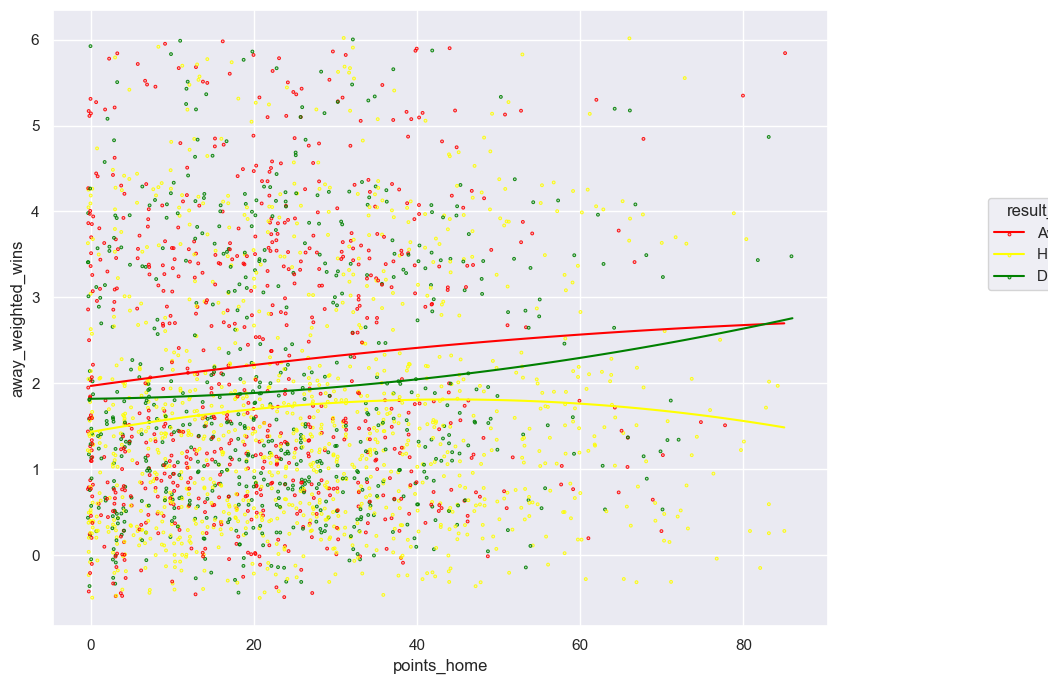

In [15]:
import seaborn.objects as so

palette = {'Away win': 'red', 'Draw': 'green', 'Home win': 'yellow'}

fig = plt.figure(figsize=(10, 8))

(so.Plot(X_train
         .assign(result_match=y_train)
         .assign(result_label=lambda df: df['result_match'].apply(lambda x: 'Away win' if x == 0 else ('Draw' if x == 1 else 'Home win'))),
x='points_home', y='away_weighted_wins',color='result_label')
 .add(so.Dots(alpha=.9, pointsize=2), so.Jitter(x=.7, y=1))
 .add(so.Line(), so.PolyFit())
 .scale(color=palette)
 .on(fig) # not required unless saving to image
 .plot()
)

plt.savefig('../plot.png')